# Imports


In [1]:
# cell 1

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import cholesky, solve_triangular
from scipy.special import kv, gamma
import seaborn as sns
import pyproj
import torch
import gpytorch
from torch.optim import Adam
from gpytorch.models import ExactGP
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood



# Load data

In [2]:
#cell 2

# Load dataset
csv_file = "C:\ASU\Semester 2\space robotics and ai\codeyy\GP\Data\dec6.csv"
data = pd.read_csv(csv_file)
print(f"Loaded {len(data)} data points from: {csv_file}")

# Display dataset info
print("First few rows of raw data:")
print(data.head())
print(f"Raw Latitude range: {data['Latitude'].min()} to {data['Latitude'].max()}")
print(f"Raw Longitude range: {data['Longitude'].min()} to {data['Longitude'].max()}")



Loaded 3989 data points from: C:\ASU\Semester 2\space robotics and ai\codeyy\GP\Data\dec6.csv
First few rows of raw data:
     Time (UTC)   Latitude   Longitude  Depth (Sonar)  Temperature (°C)    pH  \
0  1.733528e+09  33.430408 -111.928888          1.551             16.72  9.04   
1  1.733528e+09  33.430408 -111.928888          1.778             16.73  9.04   
2  1.733528e+09  33.430408 -111.928888          2.031             16.73  9.04   
3  1.733528e+09  33.430408 -111.928889          2.274             16.73  9.04   
4  1.733528e+09  33.430408 -111.928888          2.604             16.73  9.04   

   Depth (m)  Conductivity (uS/cm)  Dissolved Oxygen Saturation  \
0       0.02                  1553                        127.8   
1       0.02                  1553                        127.8   
2       0.02                  1552                        127.8   
3       0.02                  1552                        127.8   
4       0.02                  1552                      

<>:4: SyntaxWarning: invalid escape sequence '\A'
<>:4: SyntaxWarning: invalid escape sequence '\A'
C:\Users\battu\AppData\Local\Temp\ipykernel_13396\2848719260.py:4: SyntaxWarning: invalid escape sequence '\A'
  csv_file = "C:\ASU\Semester 2\space robotics and ai\codeyy\GP\Data\dec6.csv"



# Latitude/Longitude coordinates 

    (WGS84) are converted to UTM (meters) using the EPSG:32612 projection for accurate spatial mapping. 
    The `pyproj.Transformer` function applies the transformation, generating X, Y coordinates in meters. 
    A sample of the transformed data and coordinate ranges is printed for verification.


In [3]:
#cell 3

# Define coordinate reference systems (CRS)
utm_crs = pyproj.CRS("EPSG:32612")  # UTM Zone 12N for Tempe, Arizona
wgs84_crs = pyproj.CRS("EPSG:4326")  # WGS84 Latitude/Longitude

# Define transformation from WGS84 (lat/lon) to UTM (X, Y in meters)
transformer = pyproj.Transformer.from_crs(wgs84_crs, utm_crs, always_xy=True)

# Apply transformation to convert Longitude/Latitude to UTM (X, Y)
data["X_coord"], data["Y_coord"] = transformer.transform(
    data["Longitude"].values,  # Input longitude (degrees)
    data["Latitude"].values    # Input latitude (degrees)
)

# Print a sample of the transformed data
print("Sample processed data (in meters):")
print(data[["Latitude", "Longitude", "X_coord", "Y_coord"]].head())

# Print coordinate ranges after conversion
print(f"X_coord range (meters): {data['X_coord'].min()} to {data['X_coord'].max()}")
print(f"Y_coord range (meters): {data['Y_coord'].min()} to {data['Y_coord'].max()}")


Sample processed data (in meters):
    Latitude   Longitude        X_coord       Y_coord
0  33.430408 -111.928888  413649.406157  3.699389e+06
1  33.430408 -111.928888  413649.368872  3.699389e+06
2  33.430408 -111.928888  413649.378070  3.699389e+06
3  33.430408 -111.928889  413649.350180  3.699389e+06
4  33.430408 -111.928888  413649.368278  3.699389e+06
X_coord range (meters): 413595.4251371465 to 413701.0693493731
Y_coord range (meters): 3699388.488145916 to 3699507.1967617515


In [4]:
# cell 3.1 — Scale the UTM coords
from sklearn.preprocessing import StandardScaler

# original UTM coords are in data["X_coord"], data["Y_coord"]
scaler = StandardScaler()
utm_vals = data[['X_coord','Y_coord']].values
utm_scaled = scaler.fit_transform(utm_vals)

# store back into the DataFrame
data['X_scaled'], data['Y_scaled'] = utm_scaled[:,0], utm_scaled[:,1]

print(f"UTM coords scaled: mean={utm_scaled.mean(axis=0)}, std={utm_scaled.std(axis=0)}")


UTM coords scaled: mean=[-3.44167022e-13 -3.03300751e-12], std=[1. 1.]


In [5]:
# cell 4

# Downsample dataset to a maximum of 2000 points for efficiency
max_points_per_file = 1000000000
n = len(data)  # Total number of data points

# Randomly select up to `max_points_per_file` data points (ensuring reproducibility with random_state=42)
sampled_indices = data.sample(min(n, max_points_per_file), random_state=42).index
sampled_indices = sorted(sampled_indices)  # Sorting ensures consistency in data ordering

# Extract the target variable (Surface Temperature in °C)
target_var = "Temperature (°C)"
y = data[target_var].values  # Temperature values

# Extract _scaled_ spatial features for training
X_features = data[["X_scaled", "Y_scaled"]].values



# Select only the downsampled data points
X_train = X_features[sampled_indices]
y_train = y[sampled_indices]

# Print dataset details after downsampling
print(f"Total data points: {len(data)}, Training subset size: {X_train.shape[0]}")
print("Example training point (2D):", X_train[0])


Total data points: 3989, Training subset size: 3989
Example training point (2D): [ 0.04834709 -1.59649886]


In [6]:
# cell 4.1 — Re‑fit the StandardScaler on the training subset to avoid data leakage
scaler = StandardScaler()

# Grab the UTM coordinates of the sampled rows
utm_train = data.loc[sampled_indices, ['X_coord', 'Y_coord']].values
utm_train_scaled = scaler.fit_transform(utm_train)

# Overwrite the scaled columns *only* for the sampled rows
data.loc[sampled_indices, 'X_scaled'] = utm_train_scaled[:, 0]
data.loc[sampled_indices, 'Y_scaled'] = utm_train_scaled[:, 1]

# Refresh the features so X_train uses the new scaling
X_features = data[['X_scaled', 'Y_scaled']].values
X_train = X_features[sampled_indices]


In [7]:
# cell 5

# Set Gaussian Process (GP) hyperparameters

# Matérn smoothness parameter:
#   nu = 0.5  -> Exponential kernel (non-differentiable paths)
#   nu = 1.5  -> Once-differentiable paths
#   nu = 2.5  -> Twice-differentiable paths (chosen here)
#   nu → ∞    -> Equivalent to the RBF (Squared Exponential) kernel


nu = 0.5

# Signal standard deviation (sigma_f): Captures the variance of the data 
# We use the standard deviation of the training targets as a rough estimate
sigma_f = np.std(y_train)  

# Noise standard deviation (sigma_n): Accounts for observation noise
# This should be set lower if sensor measurements are very precise
sigma_n = 0.1  

# Base length scale in meters: Defines the characteristic spatial scale for the kernel
base_lengthscale_space = 5  

# Print hyperparameter values
print("\nHyperparameters:")
print(f"nu = {nu}, sigma_f = {sigma_f:.2f}, sigma_n = {sigma_n}")
print(f"base_lengthscale_space = {base_lengthscale_space} meters")

# For nonstationary kernels, allow length scales to vary across space
# We define a modulation factor (alpha) that adjusts the local length scales
alpha = 0.5  # Adjust as needed

# Compute statistical properties of training data coordinates
# mean_x, mean_y -> Mean spatial positions
mean_x = np.mean(X_train[:, 0])  
mean_y = np.mean(X_train[:, 1])  

# range_x, range_y -> Spatial range (max - min) for each coordinate
range_x = max(np.ptp(X_train[:, 0]), 1e-12)   # guard against divide‑by‑zero
range_y = max(np.ptp(X_train[:, 1]), 1e-12)




Hyperparameters:
nu = 0.5, sigma_f = 0.06, sigma_n = 0.1
base_lengthscale_space = 5 meters


In [8]:
# cell 5.1 — Center training targets for a zero-mean GP
y_mean = np.mean(y_train)
y_train_centered = y_train - y_mean
print(f"Training targets centered: mean={np.mean(y_train_centered):.3e}")


Training targets centered: mean=-1.480e-15


In [9]:
# cell 6

def Sigma_matrix(x):
    """
    Computes the local 2x2 covariance matrix for a given location x = [x_coord, y_coord].
    This matrix is nonstationary because the length scales vary with x.
    """
    sigma_x = base_lengthscale_space * (1 + alpha * (x[0] - mean_x) / range_x)
    sigma_y = base_lengthscale_space * (1 + alpha * (x[1] - mean_y) / range_y)
    # Set an off-diagonal term (here using a fixed correlation, e.g., 0.2)
    rho = 0.2
    return np.array([
        [sigma_x**2,       rho * sigma_x * sigma_y],
        [rho * sigma_x * sigma_y, sigma_y**2]
    ])



In [10]:
# cell 7

def matern_covariance(x, x_prime, nu=nu, sigma_f=sigma_f):
    """
    Computes the nonstationary Matérn covariance between 2D points x and x_prime.
    """
    Σ_i = Sigma_matrix(x)
    Σ_j = Sigma_matrix(x_prime)
    det_Si = np.linalg.det(Σ_i)
    det_Sj = np.linalg.det(Σ_j)
    det_half = np.linalg.det((Σ_i + Σ_j) / 2.0)
    diff = np.array(x) - np.array(x_prime)
    M = (Σ_i + Σ_j) / 2.0

    try:
        v = np.linalg.solve(M, diff)
        Q_ij = float(diff.dot(v))
    except np.linalg.LinAlgError:
        v = np.linalg.pinv(M).dot(diff)
        Q_ij = float(diff.dot(v))
        
    if Q_ij < 1e-12:
        return sigma_f**2

    prefactor = (det_Si**0.25) * (det_Sj**0.25) / (det_half**0.5)
    arg = np.sqrt(2 * nu * Q_ij)
    matern_part = (arg**nu) * kv(nu, arg)
    norm_const = 1.0 / (gamma(nu) * 2**(nu - 1))
    
    return sigma_f**2 * prefactor * norm_const * matern_part

print("\nNonstationary Matérn kernel (2D) defined.")




Nonstationary Matérn kernel (2D) defined.


In [11]:
# cell 8 — Compute (and jitter) the kernel matrix for training data (optimized)

# Make sure N matches the (possibly refreshed) training set size
N = X_train.shape[0]

# Precompute Σ for each training point
Sigma_list = [Sigma_matrix(x) for x in X_train]

# Initialize K and add jitter for stability
jitter = 1e-6
K = np.zeros((N, N))

for i in range(N):
    Σ_i = Sigma_list[i]
    for j in range(i, N):
        Σ_j = Sigma_list[j]
        diff = X_train[i] - X_train[j]
        M = 0.5 * (Σ_i + Σ_j)
        try:
            v = np.linalg.solve(M, diff)
        except np.linalg.LinAlgError:
            v = np.linalg.pinv(M).dot(diff)
        Q = diff.dot(v)
        if Q < 1e-12:
            cov = sigma_f**2
        else:
            arg = np.sqrt(2 * nu * Q)
            pref = (np.linalg.det(Σ_i)**0.25 * np.linalg.det(Σ_j)**0.25) / (np.linalg.det(M)**0.5)
            matern = (arg**nu) * kv(nu, arg) / (gamma(nu) * 2**(nu - 1))
            cov = sigma_f**2 * pref * matern
        K[i, j] = K[j, i] = cov

# Add noise variance + jitter
K += (sigma_n**2 + jitter) * np.eye(N)

# Cholesky & solve for weights, using centered targets
L = cholesky(K, lower=True)
alpha_weights = solve_triangular(
    L.T,
    solve_triangular(L, y_train_centered, lower=True),
    lower=False
)


In [12]:
# cell 8.1 — compute & print initial hyperparams and LML (using centred targets)

# capture initial settings
initial_ls    = base_lengthscale_space
initial_alpha = alpha

# log‑determinant of K
logdetK = 2.0 * np.sum(np.log(np.diag(L)))

# log‑marginal likelihood with centred targets
initial_lml = (
    -0.5 * y_train_centered.dot(alpha_weights)   # centred targets
    -0.5 * logdetK
    -0.5 * N * np.log(2 * np.pi)
)

print(f"INITIAL hyperparams → base_lengthscale_space={initial_ls}, alpha={initial_alpha}")
print(f"INITIAL log‑marginal‑likelihood = {initial_lml:.3f}")


INITIAL hyperparams → base_lengthscale_space=5, alpha=0.5
INITIAL log‑marginal‑likelihood = 5323.287


In [13]:
# 1) Prep data on GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_x = torch.from_numpy(X_train).float().to(device)
train_y = torch.from_numpy(y_train_centered).float().to(device)

# 2) Define Exact GP model
class GPModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood, nu):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean().to(device)
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.MaternKernel(nu=nu).to(device)
        ).to(device)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# 3) Instantiate model & likelihood
likelihood = GaussianLikelihood().to(device)
model = GPModel(train_x, train_y, likelihood, nu=0.5)

model.train()
likelihood.train()

# 4) Optimizer & loss
all_params = {id(p): p for p in list(model.parameters()) + list(likelihood.parameters())}
optimizer = Adam(list(all_params.values()), lr=0.1)
mll = ExactMarginalLogLikelihood(likelihood, model)

# 5) Training loop
for i in range(80):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    optimizer.step()
    if (i+1) % 10 == 0:
        print(f"Iter {i+1}/80 — Loss: {loss.item():.3f}")

model.eval()
likelihood.eval()

print("Learned kernel:", model.covar_module)
print("Learned noise:", likelihood.noise.item())
print("Final marginal likelihood:", mll(model(train_x), train_y).item())

# 6) (Optional) Compute alpha_weights = K⁻¹ y for compatibility
with torch.no_grad():
    post = model(train_x)                           # MultivariateNormal
    covar_mat = post.covariance_matrix               # NxN latent covariance
    jitter   = torch.eye(covar_mat.size(0), device=device) * 1e-6
    L_train  = torch.linalg.cholesky(covar_mat + jitter)
    alpha_t  = torch.cholesky_solve(train_y.unsqueeze(-1), L_train)
    alpha_weights = alpha_t.cpu().numpy().ravel()    # back to NumPy

print("Computed alpha_weights shape:", alpha_weights.shape)

Iter 10/80 — Loss: 0.436
Iter 20/80 — Loss: -0.035
Iter 30/80 — Loss: -0.542
Iter 40/80 — Loss: -1.056
Iter 50/80 — Loss: -1.558
Iter 60/80 — Loss: -2.006
Iter 70/80 — Loss: -2.356
Iter 80/80 — Loss: -2.587
Learned kernel: ScaleKernel(
  (base_kernel): MaternKernel(
    (raw_lengthscale_constraint): Positive()
  )
  (raw_outputscale_constraint): Positive()
)
Learned noise: 0.00043110863771289587


c:\ASU\Semester 2\space robotics and ai\codeyy\.venv\Lib\site-packages\gpytorch\models\exact_gp.py:296: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


Final marginal likelihood: 3.22627592086792
Computed alpha_weights shape: (3989,)


c:\ASU\Semester 2\space robotics and ai\codeyy\.venv\Lib\site-packages\linear_operator\utils\linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 6.612819671630859 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


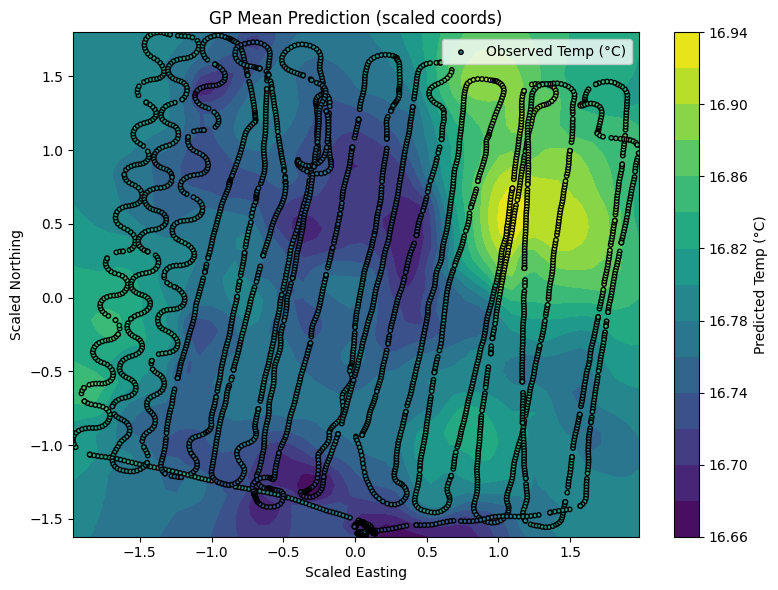

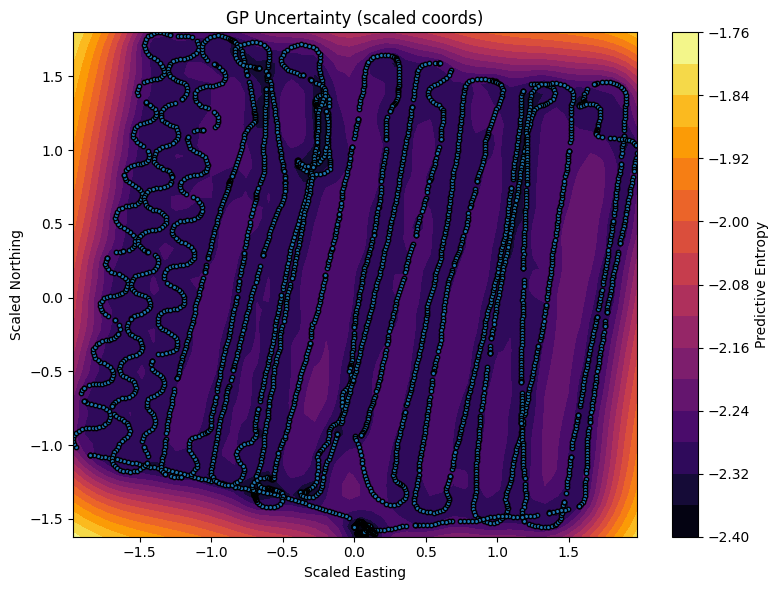

In [16]:
# cell 9_gpu — predict & plot using GPyTorch (with training points)

# 1) Build raw grid & scale it exactly as before
grid_x = np.linspace(data["X_coord"].min(), data["X_coord"].max(), 50)
grid_y = np.linspace(data["Y_coord"].min(), data["Y_coord"].max(), 50)
grid_pts_utm    = np.array([[x, y] for x in grid_x for y in grid_y])
grid_pts_scaled = scaler.transform(grid_pts_utm)

# 2) Move grid to GPU and predict
device = torch.device("cuda")
test_x = torch.from_numpy(grid_pts_scaled).float().to(device)
model.eval(); likelihood.eval()
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    pred = likelihood(model(test_x))

# 3) Extract mean & variance, restore offset, compute entropy
mu      = pred.mean.cpu().numpy() + y_mean
var     = pred.variance.cpu().numpy()
entropy = 0.5 * np.log(2 * np.pi * np.e * var)

# 4) Reshape back into meshes
n   = len(grid_x)
MU  = mu.reshape(n, n)
ENT = entropy.reshape(n, n)
X_s = grid_pts_scaled[:, 0].reshape(n, n)   # scaled easting
Y_s = grid_pts_scaled[:, 1].reshape(n, n)   # scaled northing

# 5) Plot mean with points
plt.figure(figsize=(8,6))
cs = plt.contourf(X_s, Y_s, MU, levels=15, cmap="viridis")  # no .T
plt.colorbar(cs, label="Predicted Temp (°C)")
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train,
            s=10, edgecolors='k', label="Observed Temp (°C)")
plt.xlabel("Scaled Easting")
plt.ylabel("Scaled Northing")
plt.title("GP Mean Prediction (scaled coords)")
plt.legend()
plt.tight_layout()
plt.show()

# 6) Plot uncertainty with points
plt.figure(figsize=(8,6))
cs2 = plt.contourf(X_s, Y_s, ENT, levels=15, cmap="inferno")  # no .T
plt.colorbar(cs2, label="Predictive Entropy")
plt.scatter(X_train[:, 0], X_train[:, 1],
            s=10, edgecolors='k')
plt.xlabel("Scaled Easting")
plt.ylabel("Scaled Northing")
plt.title("GP Uncertainty (scaled coords)")
plt.tight_layout()
plt.show()


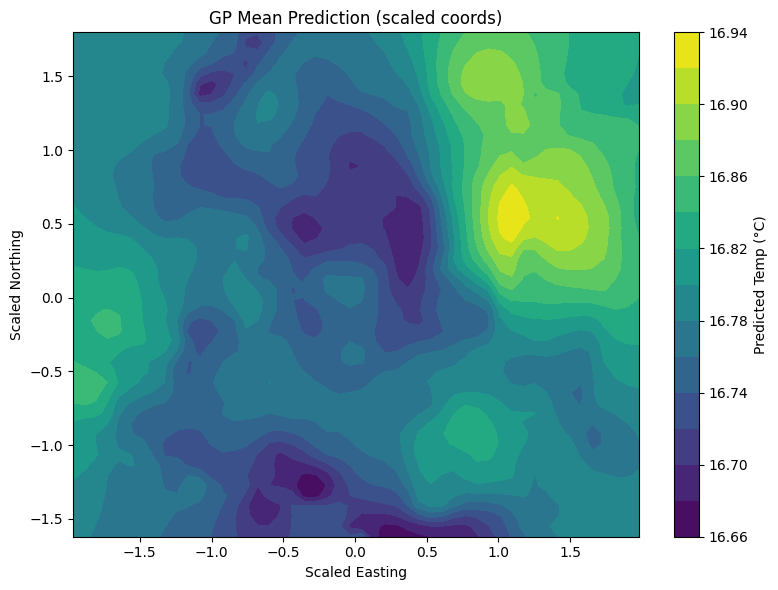

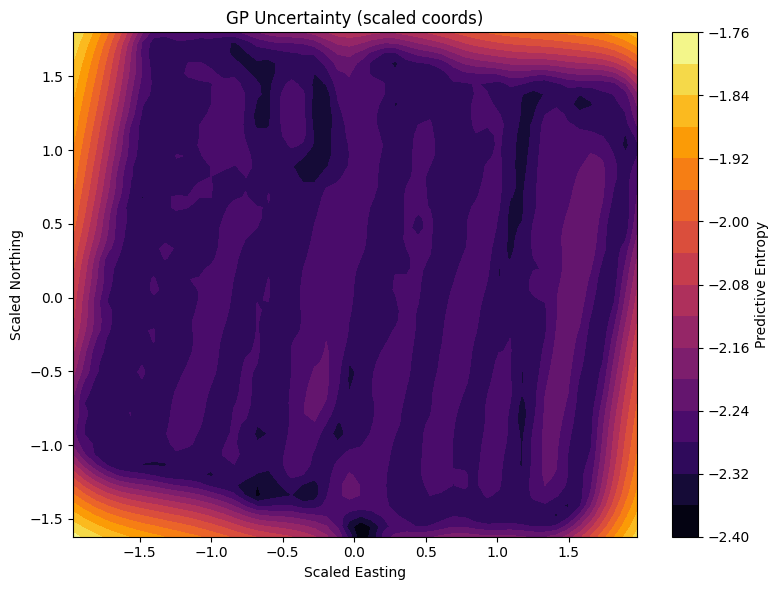

In [17]:
# cell 9_gpu — predict & plot using GPyTorch (no training points)

# 1) Build raw grid & scale it
grid_x = np.linspace(data["X_coord"].min(), data["X_coord"].max(), 50)
grid_y = np.linspace(data["Y_coord"].min(), data["Y_coord"].max(), 50)
grid_pts_utm    = np.array([[x, y] for x in grid_x for y in grid_y])
grid_pts_scaled = scaler.transform(grid_pts_utm)

# 2) GPU predict
device = torch.device("cuda")
test_x = torch.from_numpy(grid_pts_scaled).float().to(device)
model.eval(); likelihood.eval()
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    pred = likelihood(model(test_x))

# 3) Extract & reshape
mu      = pred.mean.cpu().numpy() + y_mean
var     = pred.variance.cpu().numpy()
entropy = 0.5 * np.log(2 * np.pi * np.e * var)

n   = len(grid_x)
MU  = mu.reshape(n, n)
ENT = entropy.reshape(n, n)
X_s = grid_pts_scaled[:, 0].reshape(n, n)
Y_s = grid_pts_scaled[:, 1].reshape(n, n)

# 4) Plot mean only
plt.figure(figsize=(8,6))
cs = plt.contourf(X_s, Y_s, MU, levels=15, cmap="viridis")  # no .T
plt.colorbar(cs, label="Predicted Temp (°C)")
plt.xlabel("Scaled Easting")
plt.ylabel("Scaled Northing")
plt.title("GP Mean Prediction (scaled coords)")
plt.tight_layout()
plt.show()

# 5) Plot uncertainty only
plt.figure(figsize=(8,6))
cs2 = plt.contourf(X_s, Y_s, ENT, levels=15, cmap="inferno")  # no .T
plt.colorbar(cs2, label="Predictive Entropy")
plt.xlabel("Scaled Easting")
plt.ylabel("Scaled Northing")
plt.title("GP Uncertainty (scaled coords)")
plt.tight_layout()
plt.show()


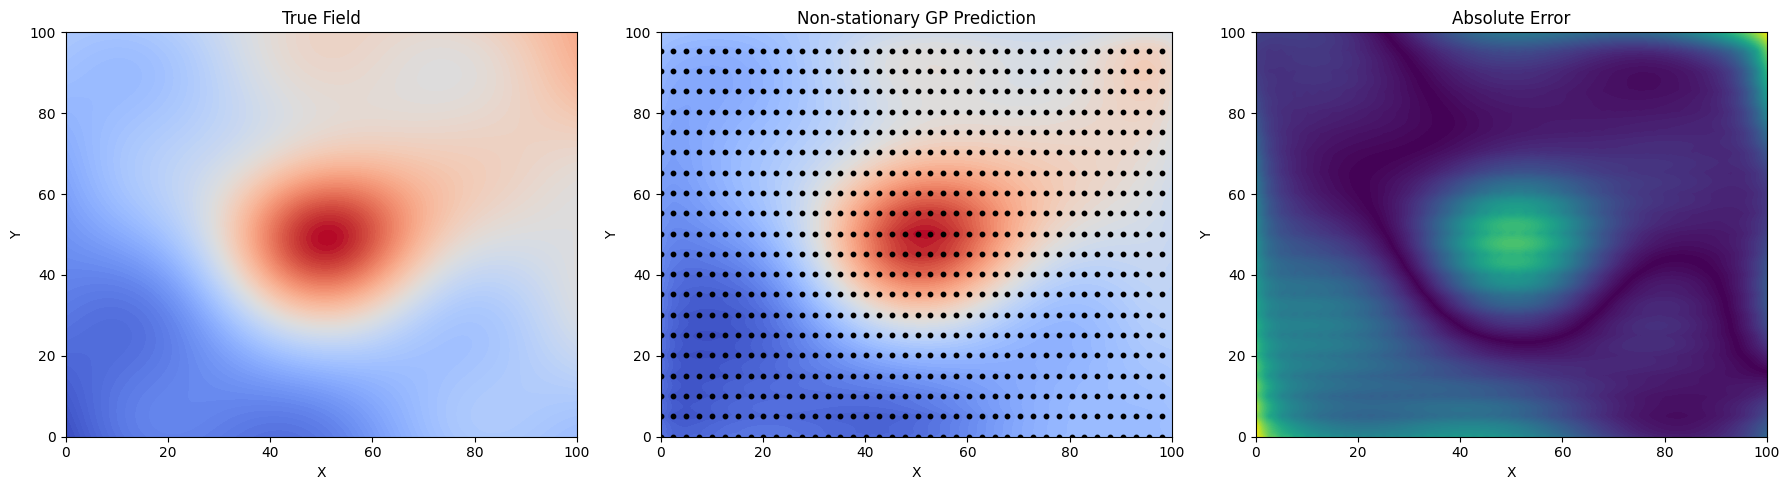

In [19]:
# cell 13_nonstationary — artificial field GP regression with non-stationary Matérn kernel

# 1) Define a true field function (same as stationary test)
def true_field(x, y):
    return (np.sin(0.1 * x) * np.cos(0.1 * y) +
            0.05 * x + 0.05 * y +
            10 * np.exp(-((x - 50)**2 + (y - 50)**2) / (2 * 200)))

# 2) Create a high-resolution grid for the true field
x_range = np.linspace(0, 100, 200)
y_range = np.linspace(0, 100, 200)
lon_mesh_art, lat_mesh_art = np.meshgrid(x_range, y_range)
grid_coords = np.vstack([lat_mesh_art.ravel(), lon_mesh_art.ravel()]).T
Z_true = true_field(grid_coords[:,1], grid_coords[:,0]).reshape(lat_mesh_art.shape)

# 3) Simulate a lawnmower survey
lawnmower_rows = np.arange(0, 200, 10)
sample_x, sample_y = [], []
for r in lawnmower_rows:
    for c in np.arange(0, 200, 5):
        sample_x.append(lon_mesh_art[r, c])
        sample_y.append(lat_mesh_art[r, c])
sample_x = np.array(sample_x)
sample_y = np.array(sample_y)

# 4) Prepare artificial training data
X_art = np.vstack([sample_x, sample_y]).T       # shape (N_art, 2)
y_art = true_field(sample_x, sample_y)          # shape (N_art,)
y_mean_art = np.mean(y_art)
y_centered = y_art - y_mean_art

# 5) Compute spatial statistics for the artificial samples
mean_x_art, mean_y_art = X_art.mean(axis=0)
range_x_art = np.ptp(X_art[:,0]) or 1e-12
range_y_art = np.ptp(X_art[:,1]) or 1e-12

# 6) Define local covariance matrix and non-stationary Matérn
def Sigma_matrix_art(x):
    sigma_x = base_lengthscale_space * (1 + alpha * (x[0] - mean_x_art) / range_x_art)
    sigma_y = base_lengthscale_space * (1 + alpha * (x[1] - mean_y_art) / range_y_art)
    rho = 0.2
    return np.array([
        [sigma_x**2,        rho * sigma_x * sigma_y],
        [rho * sigma_x * sigma_y, sigma_y**2        ]
    ])

def ns_matern(x, x_prime):
    Σ_i = Sigma_matrix_art(x)
    Σ_j = Sigma_matrix_art(x_prime)
    M = 0.5 * (Σ_i + Σ_j)
    diff = x - x_prime
    try:
        invM = np.linalg.inv(M)
    except np.linalg.LinAlgError:
        invM = np.linalg.pinv(M)
    Q = float(diff.dot(invM).dot(diff))
    if Q < 1e-12:
        return sigma_f**2
    det_Si = np.linalg.det(Σ_i)
    det_Sj = np.linalg.det(Σ_j)
    pref = (det_Si**0.25 * det_Sj**0.25) / (np.linalg.det(M)**0.5)
    arg  = np.sqrt(2 * nu * Q)
    matern = (arg**nu) * kv(nu, arg) / (gamma(nu) * 2**(nu - 1))
    return sigma_f**2 * pref * matern

# 7) Build and jitter the training kernel matrix K_art
N_art = X_art.shape[0]
jitter = 1e-6
K_art = np.zeros((N_art, N_art))
for i in range(N_art):
    for j in range(i, N_art):
        cov_ij = ns_matern(X_art[i], X_art[j])
        K_art[i,j] = cov_ij
        K_art[j,i] = cov_ij
K_art += (sigma_n**2 + jitter) * np.eye(N_art)

# 8) Compute α = (K_art)⁻¹ y_centered via Cholesky
L_art = cholesky(K_art, lower=True)
alpha_art = solve_triangular(
    L_art.T,
    solve_triangular(L_art, y_centered, lower=True),
    lower=False
)

# 9) Prepare prediction grid and compute cross-covariances
grid_pts = np.vstack([lon_mesh_art.ravel(), lat_mesh_art.ravel()]).T
M_pred = grid_pts.shape[0]
K_star = np.zeros((N_art, M_pred))
for i in range(N_art):
    for j in range(M_pred):
        K_star[i,j] = ns_matern(X_art[i], grid_pts[j])

# 10) Predictive mean and (diagonal) variance
mu_pred = K_star.T.dot(alpha_art) + y_mean_art
var_pred = np.array([ns_matern(pt, pt) for pt in grid_pts]) + sigma_n**2

# 11) Reshape and plot results
Z_pred_ns = mu_pred.reshape(lat_mesh_art.shape)
error_ns  = np.abs(Z_true - Z_pred_ns)

plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
plt.contourf(lon_mesh_art, lat_mesh_art, Z_true, levels=100, cmap='coolwarm')
plt.title("True Field"); plt.xlabel("X"); plt.ylabel("Y")

plt.subplot(1,3,2)
plt.contourf(lon_mesh_art, lat_mesh_art, Z_pred_ns, levels=100, cmap='coolwarm')
plt.scatter(sample_x, sample_y, c='k', s=10, label='Samples')
plt.title("Non-stationary GP Prediction"); plt.xlabel("X"); plt.ylabel("Y")

plt.subplot(1,3,3)
plt.contourf(lon_mesh_art, lat_mesh_art, error_ns, levels=100, cmap='viridis')
plt.title("Absolute Error"); plt.xlabel("X"); plt.ylabel("Y")

plt.tight_layout()
plt.show()